In [1]:
import sys
sys.path.append('/home/jlbernal/lim/')
sys.path.append('/home/jlbernal/preLIMinary/')
from LIM_lightcone import paint_lightcone,make_survey,make_measurements
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp2d,interp1d
from scipy.optimize import curve_fit
import math
from lim import lim

from nbodykit.algorithms import FFTPower

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection

colors = ['#8a1f1f','#79a43a','#C59D34','#171782', '#cf6717','#ad6faa',
          '#009999','#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

%matplotlib inline


In [2]:
def linear_color(col1,col2):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

#############################################

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

# Setting parameters

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys,z,Dz,sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              Omega_field = 100,dnu=10):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    nuObs, Dnu = Dnu_from_Dz(nu, z, Dz)
    model_params = dict(nu=nu, nuObs=nuObs, 
                        sigma_scatter=sigma_scatter,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':SFR_file,'sig_SFR':sig_SFR},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=False, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10000, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=dnu*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=Nfeeds, 
                      beam_FWHM=beam*u.arcmin, 
                      tobs=tobs*u.hr,
                      Omega_field=Omega_field*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys,
              zmin_obs, zmax_obs,zmin=2.2,zmax=3.5,
              sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              alpha = 1.37, beta = -1.74,
              dnu=10,
              RAObs_edge = 10, DECObs_edge = 10,smooth=False):
    nu_CO=115.271*u.GHz

    model_params=dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':alpha,'beta':beta,'delta_mf':1,'sigma_L':sigma_scatter})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.01*u.Mpc**-1)
    obs_params=dict(zmin = zmin, zmax = zmax,
                    RAObs_min=-RAObs_edge*u.deg,RAObs_max=RAObs_edge*u.deg,
                    DECObs_min=-DECObs_edge*u.deg,DECObs_max=DECObs_edge*u.deg,
                    RA_min=-10.0*u.deg,RA_max=10.0*u.deg,
                    DEC_min=-10.0*u.deg,DEC_max=10.0*u.deg,
                    nuObs_max=nu_CO/(1+zmin_obs), nuObs_min=nu_CO/(1+zmax_obs),
                    beam_FWHM=beam*u.arcmin, 
                    dnu=dnu*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=Nfeeds, 
                    tobs=tobs*u.hr,
                    linear_VID_bin=True, Tmin_VID =-0.5*u.uK,Nbin_hist=50,Tmax_VID=100*u.uK,
                    do_smooth=False,remove_noise=True)
    obs_params.update(model_params)
    return obs_params

# Set maps

In [32]:
#We need to implement more lines, so far adding the same line artificially at different redshifts
#    rather than having line-interlopers

CO = make_measurements(LC_params(do_exSFR=False, exSFR='', exSFR_pars=dict([]), Tsys=0.,
              zmin_obs=2.15, zmax_obs=2.25,zmin=0.,zmax=4.,
              sigma_scatter=0.3,sig_SFR=0.3,
              Nfeeds = 100, beam = 4, tobs = 1000,
              dnu=20,
              RAObs_edge = 10, DECObs_edge = 10,smooth=True))


In [33]:
dmf = [1,0.01]

In [34]:
zmin_obs = [2.15,2.75]
zmax_obs = [2.25,2.85]

In [35]:
import healpy as hp

In [36]:
nu_CO = 115.271*u.GHz

In [37]:
len((hp_map!=0)==True)

50331648

In [38]:
len(pix_within)

490838

In [54]:
count = 0
for d in dmf:
    mm = []
    for iz in range(2):
        standard = {'CO': {'model_name': 'CO_Li16',
      'model_pars': {'alpha': 1.37, 'beta': -1.74, 'delta_mf': d, 'sigma_L': 0.3}}}
        CO.update(seed=0,do_angular=True,do_inner_cut=False,angular_map=True,
                 models=standard,average_angular_proj=False,
                 nuObs_max=nu_CO/(1+zmin_obs[iz]), nuObs_min=nu_CO/(1+zmax_obs[iz]))
        mm.append(CO.obs_2d_map)
        print(np.mean(CO.obs_2d_map[pix_within]),zmin_obs[iz],zmax_obs[iz])
    aa = np.zeros(len(mm[0]))
    for i in range(len(mm)):
        aa += mm[i]
    #print(np.mean())
    hp.write_map("../../maps/2peak_map_nonaveraged_noiseless_boost"+str(count)+".fits", aa, overwrite=True,dtype='float32')
    count += 1
    


0.029268282900377206 2.15 2.25
0.05803111650643333 2.75 2.85
0.8438228623113914 2.15 2.25
1.6730733253238776 2.75 2.85


In [50]:
np.mean(aa[np.where(aa!=0)[0]])

2.5350938

In [51]:
np.mean(aa[pix_within])

2.5168962

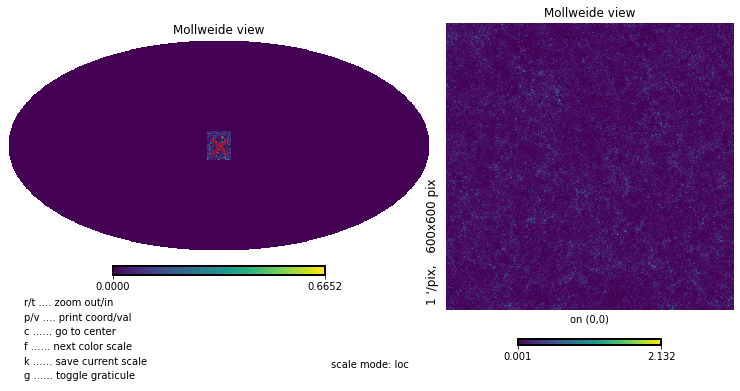

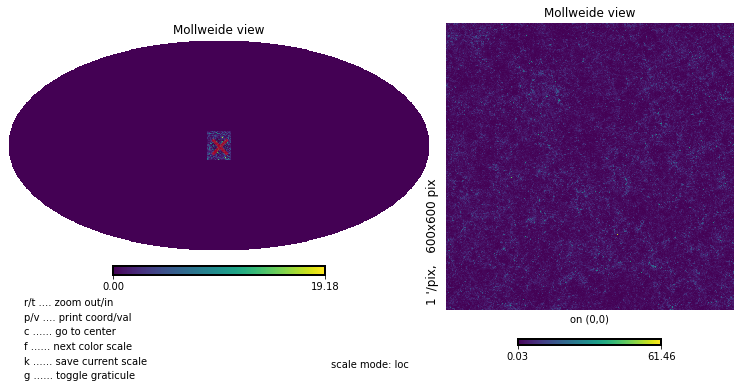

In [40]:
count = 0
for d in dmf:
    aa = hp.read_map("../../maps/2peak_map_nonaveraged_noiseless_boost"+str(count)+".fits")
    hp.mollzoom(aa)

    count += 1

# Halo catalog

In [32]:
from astropy.io import fits


In [33]:
CO.halo_catalog

array([(-2.8376331, -2.1186316, 0.00409733, -0.00081954,       12577961440, 7.8130997e+11, 3.7853590e+10, 2.7024915 ),
       (-2.2731044, -1.5934242, 0.00409954, -0.00076745, 14000010432228948, 4.0745234e+10, 0.0000000e+00, 0.        ),
       (-2.726137 , -2.0398452, 0.00409357, -0.00099676,  4000011981312656, 3.4581271e+10, 0.0000000e+00, 0.        ),
       ...,
       ( 9.698702 , -9.671411 , 3.9165385 , -0.00251267,        1183428072, 3.6130001e+10, 4.5986532e+07, 0.14456496),
       ( 9.8133545, -9.787081 , 3.9042256 ,  0.00355805,        1183781015, 4.5162000e+10, 3.1413334e+08, 0.14371905),
       ( 9.814582 , -9.780166 , 3.90388   ,  0.00377241,        1183781016, 3.1613999e+10, 6.8379025e+06, 0.0412906 )],
      dtype=(numpy.record, [('RA', '>f4'), ('DEC', '>f4'), ('Z', '>f4'), ('DZ', '>f4'), ('ID', '>i8'), ('M_HALO', '>f4'), ('SM_HALO', '>f4'), ('SFR_HALO', '>f4')]))

In [35]:
c1 = fits.Column(name='RA', array=CO.halo_catalog['RA'], format='E')
c2 = fits.Column(name='DEC', array=CO.halo_catalog['DEC'], format='E')
c3 = fits.Column(name='Z', array=CO.halo_catalog['Z'], format='E')
c4 = fits.Column(name='DZ', array=CO.halo_catalog['DZ'], format='E')
c5 = fits.Column(name='M_HALO', array=CO.halo_catalog['M_HALO'], format='E')
c6 = fits.Column(name='SM_HALO', array=CO.halo_catalog['SM_HALO'], format='E')
c7 = fits.Column(name='SFR_HALO', array=CO.halo_catalog['SFR_HALO'], format='E')


t = fits.BinTableHDU.from_columns([c1, c2, c3,c4,c5,c6,c7])
t.writeto('../../maps/halo_catalog.fits')

# Get the dI/dz

In [9]:
import numpy as np
import dask.array as da
import astropy.units as u
import astropy.constants as cu
from astropy.io import fits
import copy
import pmesh
from nbodykit.source.mesh.catalog import CompensateCICShotnoise
import healpy as hp
from source.lightcone import Lightcone
from source.utilities import cached_survey_property,get_default_params,check_params
from source.utilities import set_lim

In [10]:
def rd2tp(ra,dec):
    """ convert ra/dec to theta,phi"""

    phi = ra*np.pi/180
    
    theta = np.pi/180 * (90. - dec)
    return theta, phi

In [16]:
line = 'CO'

standard = {'CO': {'model_name': 'CO_Li16',
      'model_pars': {'alpha': 1.37, 'beta': -1.74, 'delta_mf': dmf[0], 'sigma_L': 0.3}}}

CO.update(seed=0,do_angular=True,do_inner_cut=False,angular_map=True,
                 models=standard,average_angular_proj=False,
                 nuObs_max=nu_CO/(1+zmin_obs[0]), nuObs_min=nu_CO/(1+zmax_obs[0]))

npix = hp.nside2npix(CO.nside)
hp_map = np.zeros(npix)

ra,dec,redshift = da.broadcast_arrays(CO.halos_in_survey[line]['RA'], CO.halos_in_survey[line]['DEC'],
                                      CO.halos_in_survey[line]['Zobs'])


Zhalo = CO.halos_in_survey[line]['Ztrue']
Hubble = CO.cosmo.hubble_parameter(Zhalo)*(u.km/u.Mpc/u.s)


#Figure out what channel the halos will be in to figure out the voxel volume, for the signal. 
#This is what will be added to the healpy map.

#Figure out which channel each line will end up in
nu_bins = CO.nuObs_min.to('GHz').value + np.arange(CO.Nchan)*CO.dnu.to('GHz').value 

zmid_channel = nu_bins + 0.5*CO.dnu.to('GHz').value

#Channel of each halo, can now compute voxel volumes where each of them are seamlessly
bin_idxs = np.digitize(CO.line_nu0[line].to('GHz').value/(1+Zhalo), nu_bins)-1

zmids = zmid_channel[bin_idxs]

#Vcell = Omega_pix * D_A (z)^2 * (1+z) * Dnu/nu * c/H is the volume of the voxel for a given channel
Vcell_true = hp.nside2pixarea(CO.nside)*(CO.cosmo.comoving_radial_distance(zmids)*u.Mpc )**2 * (1 + zmids) * (CO.delta_nuObs/CO.line_nu0[line]) * (cu.c.to('km/s')/Hubble)

#Paste the signals to the map
theta, phi = rd2tp(CO.halos_in_survey[line]['RA'], CO.halos_in_survey[line]['DEC'])

pixel_idxs = hp.ang2pix(CO.nside, theta, phi)

#Define the mask from the rectangular footprint
phicorner = np.deg2rad(np.array([CO.RAObs_min.value,CO.RAObs_min.value,CO.RAObs_max.value,CO.RAObs_max.value]))
thetacorner = np.pi/2-np.deg2rad(np.array([CO.DECObs_min.value,CO.DECObs_max.value,CO.DECObs_max.value,CO.DECObs_min.value]))
vecs = hp.dir2vec(thetacorner,phi=phicorner).T
pix_within = hp.query_polygon(nside=CO.nside,vertices=vecs,inclusive=False)

dIdz_p1 = [np.zeros(len(zmid_channel)),np.zeros(len(zmid_channel))]

signal = []
for d in dmf:
    standard = {'CO': {'model_name': 'CO_Li16',
      'model_pars': {'alpha': 1.37, 'beta': -1.74, 'delta_mf': d, 'sigma_L': 0.3}}}
    CO.update(seed=0,do_angular=True,do_inner_cut=False,angular_map=True,
                 models=standard,average_angular_proj=False,
                 nuObs_max=nu_CO/(1+zmin_obs[0]), nuObs_min=nu_CO/(1+zmax_obs[0]))
    
    signal.append((cu.c**3*(1+Zhalo)**2/(8*np.pi*cu.k_B*CO.line_nu0[line]**3*Hubble)*CO.halos_in_survey[line]['Lhalo']/Vcell_true).to(CO.unit))



/home/jlbernal/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


In [17]:
for iz in range(len(zmid_channel)):
    print(iz)
    inds = np.where(bin_idxs == iz)
    for isig in range(len(signal)):
        hp_map[:] = 0
        np.add.at(hp_map, pixel_idxs[bin_idxs[inds]], signal[isig][bin_idxs[inds]].value)
        dIdz_p1[isig][iz] = np.mean(hp_map[pix_within])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


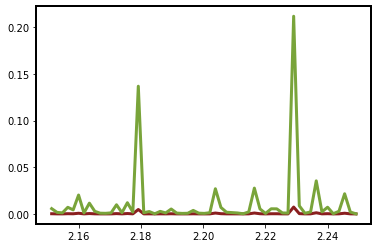

In [21]:
plt.plot(nu_CO.value/zmid_channel-1, dIdz_p1[0])
plt.plot(nu_CO.value/zmid_channel-1, dIdz_p1[1])

In [48]:


if CO.do_intensity:
    #intensity[Jy/sr]
    signal = (cu.c/(4.*np.pi*CO.line_nu0[line]*Hubble*(1.*u.sr))*CO.halos_in_survey[line]['Lhalo']/Vcell_true).to(CO.unit)
else:
    #Temperature[uK]
    signal = (cu.c**3*(1+Zhalo)**2/(8*np.pi*cu.k_B*CO.line_nu0[line]**3*Hubble)*CO.halos_in_survey[line]['Lhalo']/Vcell_true).to(CO.unit)


dIdz = np.zeros(len(zmids))

for iz in bin_idxs:
    hp_map[:] = 0
    inds = np.where(bin_idxs == iz)
    if CO.average_angular_proj:
        #averaging over the number of channels
        np.add.at(hp_map, pixel_idxs[bin_idxs[inds]], signal[bin_idxs[inds]].value/CO.Nchan)
    else:
        np.add.at(hp_map, pixel_idxs[bin_idxs[inds]], signal[bin_idxs[inds]].value)
    dIdz[iz] = np.mean(hp_map[pix_within])

KeyboardInterrupt: 

In [45]:
nu_CO.value/zmids-1

array([2.75102673, 2.75102673, 2.75102673, ..., 2.84871455, 2.8435813 ,
       2.84614621])

In [ ]:
line = 'CO'

npix = hp.nside2npix(CO.nside)
hp_map = np.zeros(npix)

ra,dec,redshift = da.broadcast_arrays(CO.halos_in_survey[line]['RA'], CO.halos_in_survey[line]['DEC'],
                                      CO.halos_in_survey[line]['Zobs'])


Zhalo = CO.halos_in_survey[line]['Ztrue']
Hubble = CO.cosmo.hubble_parameter(Zhalo)*(u.km/u.Mpc/u.s)


#Figure out what channel the halos will be in to figure out the voxel volume, for the signal. 
#This is what will be added to the healpy map.

#Figure out which channel each line will end up in
nu_bins = CO.nuObs_min.to('GHz').value + np.arange(CO.Nchan)*CO.dnu.to('GHz').value 

zmid_channel = nu_bins + 0.5*CO.dnu.to('GHz').value

#Channel of each halo, can now compute voxel volumes where each of them are seamlessly
bin_idxs = np.digitize(CO.line_nu0[line].to('GHz').value/(1+Zhalo), nu_bins)-1

zmids = zmid_channel[bin_idxs]

#Vcell = Omega_pix * D_A (z)^2 * (1+z) * Dnu/nu * c/H is the volume of the voxel for a given channel
Vcell_true = hp.nside2pixarea(CO.nside)*(CO.cosmo.comoving_radial_distance(zmids)*u.Mpc )**2 * (1 + zmids) * (CO.delta_nuObs/CO.line_nu0[line]) * (cu.c.to('km/s')/Hubble)


if CO.do_intensity:
    #intensity[Jy/sr]
    signal = (cu.c/(4.*np.pi*CO.line_nu0[line]*Hubble*(1.*u.sr))*CO.halos_in_survey[line]['Lhalo']/Vcell_true).to(CO.unit)
else:
    #Temperature[uK]
    signal = (cu.c**3*(1+Zhalo)**2/(8*np.pi*cu.k_B*CO.line_nu0[line]**3*Hubble)*CO.halos_in_survey[line]['Lhalo']/Vcell_true).to(CO.unit)


#Define the mask from the rectangular footprint
phicorner = np.deg2rad(np.array([CO.RAObs_min.value,CO.RAObs_min.value,CO.RAObs_max.value,CO.RAObs_max.value]))
thetacorner = np.pi/2-np.deg2rad(np.array([CO.DECObs_min.value,CO.DECObs_max.value,CO.DECObs_max.value,CO.DECObs_min.value]))
vecs = hp.dir2vec(thetacorner,phi=phicorner).T
pix_within = hp.query_polygon(nside=CO.nside,vertices=vecs,inclusive=False)

#Paste the signals to the map
theta, phi = rd2tp(CO.halos_in_survey[line]['RA'], CO.halos_in_survey[line]['DEC'])

pixel_idxs = hp.ang2pix(CO.nside, theta, phi)

if CO.average_angular_proj:
    #averaging over the number of channels
    np.add.at(hp_map, pixel_idxs, signal.value/CO.Nchan)
else:
    np.add.at(hp_map, pixel_idxs, signal.value)
#should smoothing be after masking?
#could lead to bleeding of the zeros with the boundary
if CO.do_smooth:
    theta_beam = CO.beam_FWHM.to(u.rad)
    hp_map = hp.smoothing(hp_map, theta_beam.value)

#Define the mask from the rectangular footprint
phicorner = np.deg2rad(np.array([CO.RAObs_min.value,CO.RAObs_min.value,CO.RAObs_max.value,CO.RAObs_max.value]))
thetacorner = np.pi/2-np.deg2rad(np.array([CO.DECObs_min.value,CO.DECObs_max.value,CO.DECObs_max.value,CO.DECObs_min.value]))
vecs = hp.dir2vec(thetacorner,phi=phicorner).T
pix_within = hp.query_polygon(nside=CO.nside,vertices=vecs,inclusive=False)
CO.pix_within = pix_within
mask = np.ones(hp.nside2npix(CO.nside),np.bool)
mask[pix_within] = 0
hp_map = hp.ma(hp_map)
hp_map.mask = mask